In [1]:
#Load dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes
import pandas as pd
import numpy as np

diabetes = load_diabetes()
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
X = df.copy()
y = pd.DataFrame(diabetes.target.copy(), columns=['target'])

In [2]:
#Prepare train and test sets for feature selection
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=123)
print(f'Train sets shapes: {X_train.shape}, {y_train.shape}')

Train sets shapes: (375, 10), (375, 1)


Model:  XGBRegressor
Validation test_score:  0.4629812448078895  train_score:  0.503872956635694
          model  test_score  train_score
0  XGBRegressor    0.474221     0.999996


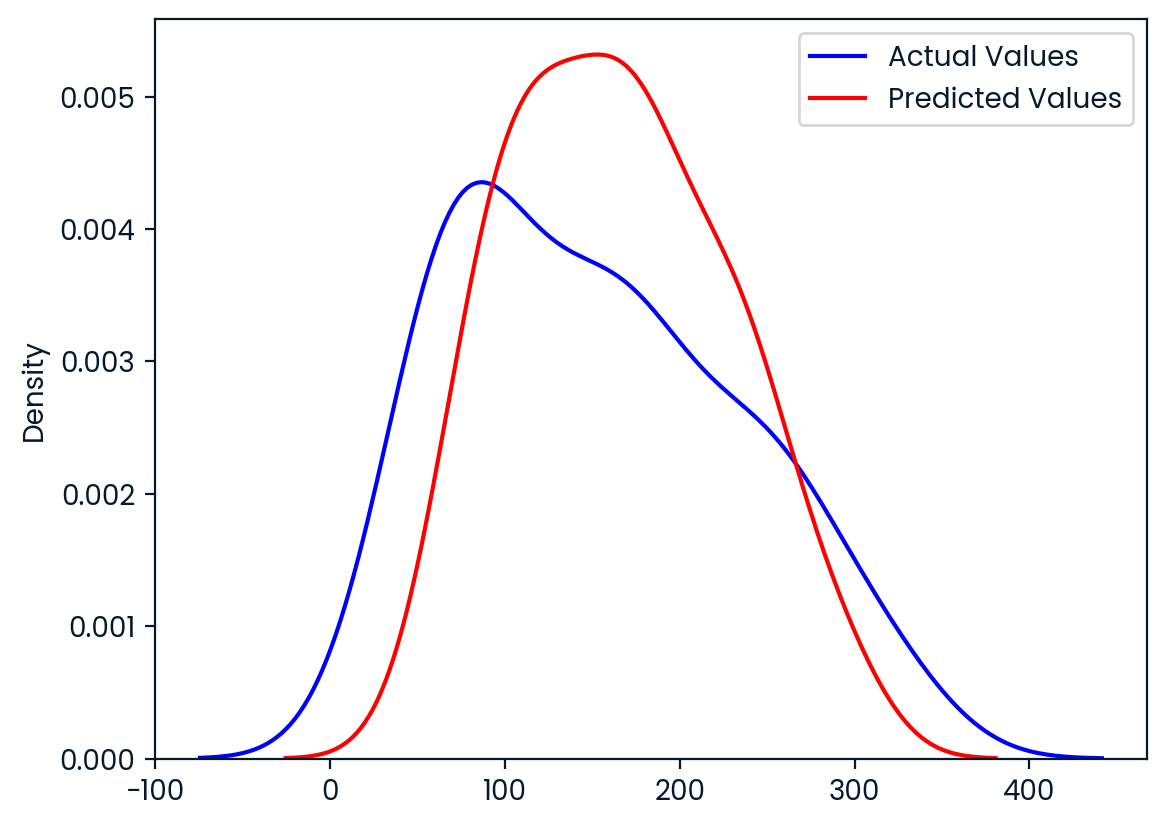

In [12]:
#Import necessary components
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb

dataset_scores = pd.DataFrame(columns=['model', 'test_score', 'train_score'])

model_name = 'XGBRegressor'
print('Model: ', model_name)

#Baseline score
cv = cross_validate(LinearRegression(), X_train, y_train, cv=5, scoring='r2', return_train_score=True)
print('Validation test_score: ', cv['test_score'].mean(), ' train_score: ', cv['train_score'].mean())

#Fit model with and calculate scores

model = xgb.XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)      
test_score= model.score(X_test, y_test)
train_score= model.score(X_train, y_train)

row = [model_name, test_score, train_score]
dataset_scores.loc[len(dataset_scores)+1] = row
dataset_scores = dataset_scores.reset_index(drop=True)

print(dataset_scores.sort_values('test_score', ascending=False))

ax1 = sns.distplot(y_test, hist=False, color="b", label="Actual Values")
sns.distplot(y_pred , hist=False, color="r", label="Predicted Values" , ax=ax1)
plt.legend()
plt.show()

Model:  XGBRegressor_tuned
Best estimator: max_depth:2, n_estimators:50, learning_rate:0.0944
                model  test_score  train_score
1  XGBRegressor_tuned    0.585259     0.603540
0        XGBRegressor    0.474221     0.999996


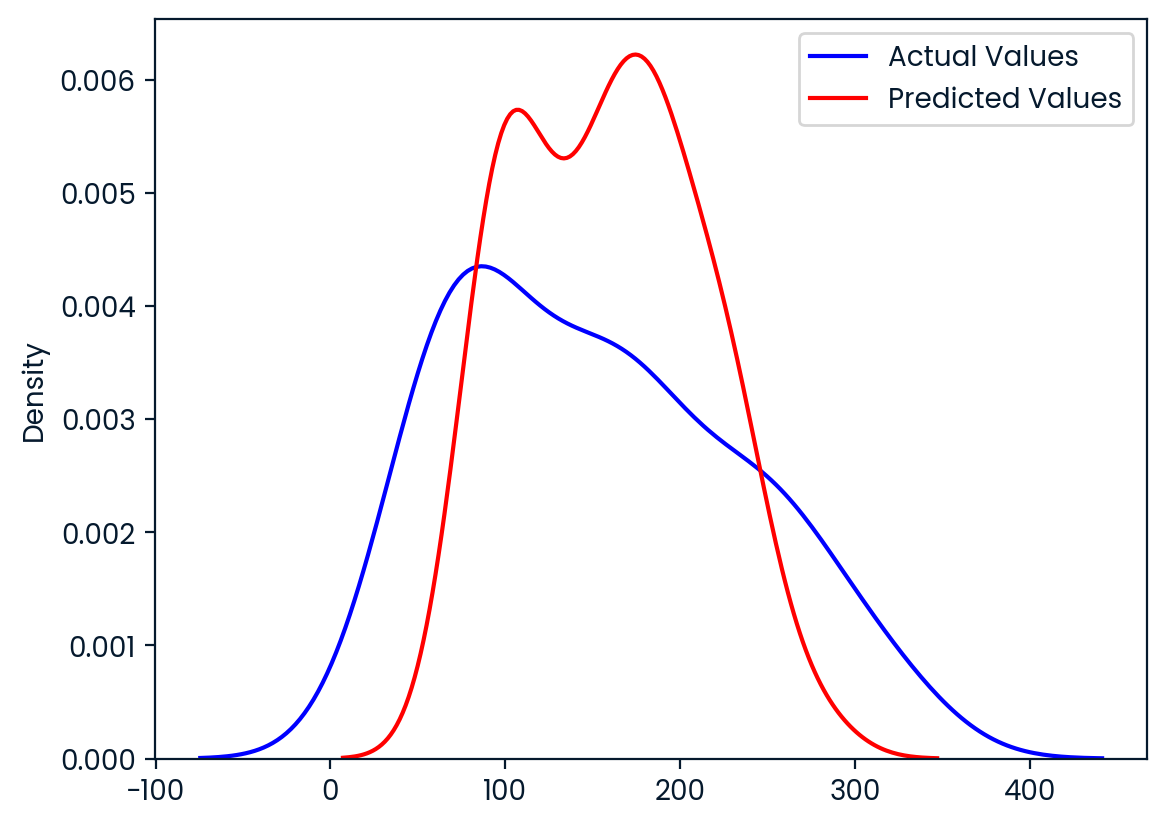

In [13]:
#Tune model
model_name = 'XGBRegressor_tuned'
print('Model: ', model_name)

parameters_grid = {'max_depth': [2, 3, 4], 
                   'learning_rate': list(np.linspace(0.05, 0.1, 10)),
                   'n_estimators': [50]}
parameters_grid = {'max_depth': [2], 
                   'learning_rate': [0.0944],
                   'n_estimators': [50]}

xgboost = xgb.XGBRegressor(random_state=123)

xgb_gscv = GridSearchCV(xgboost, parameters_grid, cv=5, scoring="r2", return_train_score=True)
xgb_gscv.fit(X_train, y_train)
cv_results = xgb_gscv.cv_results_

print(f'Best estimator: max_depth:{xgb_gscv.best_estimator_.max_depth}, n_estimators:{xgb_gscv.best_estimator_.n_estimators}, learning_rate:{xgb_gscv.best_estimator_.learning_rate}')

model = xgb_gscv.best_estimator_
y_pred = model.predict(X_test)
test_score= model.score(X_test, y_test)
train_score= model.score(X_train, y_train)


row = [model_name, test_score, train_score]
dataset_scores.loc[len(dataset_scores)+1] = row
dataset_scores = dataset_scores.reset_index(drop=True)

print(dataset_scores.sort_values('test_score', ascending=False))


ax1 = sns.distplot(y_test, hist=False, color="b", label="Actual Values")
sns.distplot(y_pred , hist=False, color="r", label="Predicted Values" , ax=ax1)
plt.legend()
plt.show()

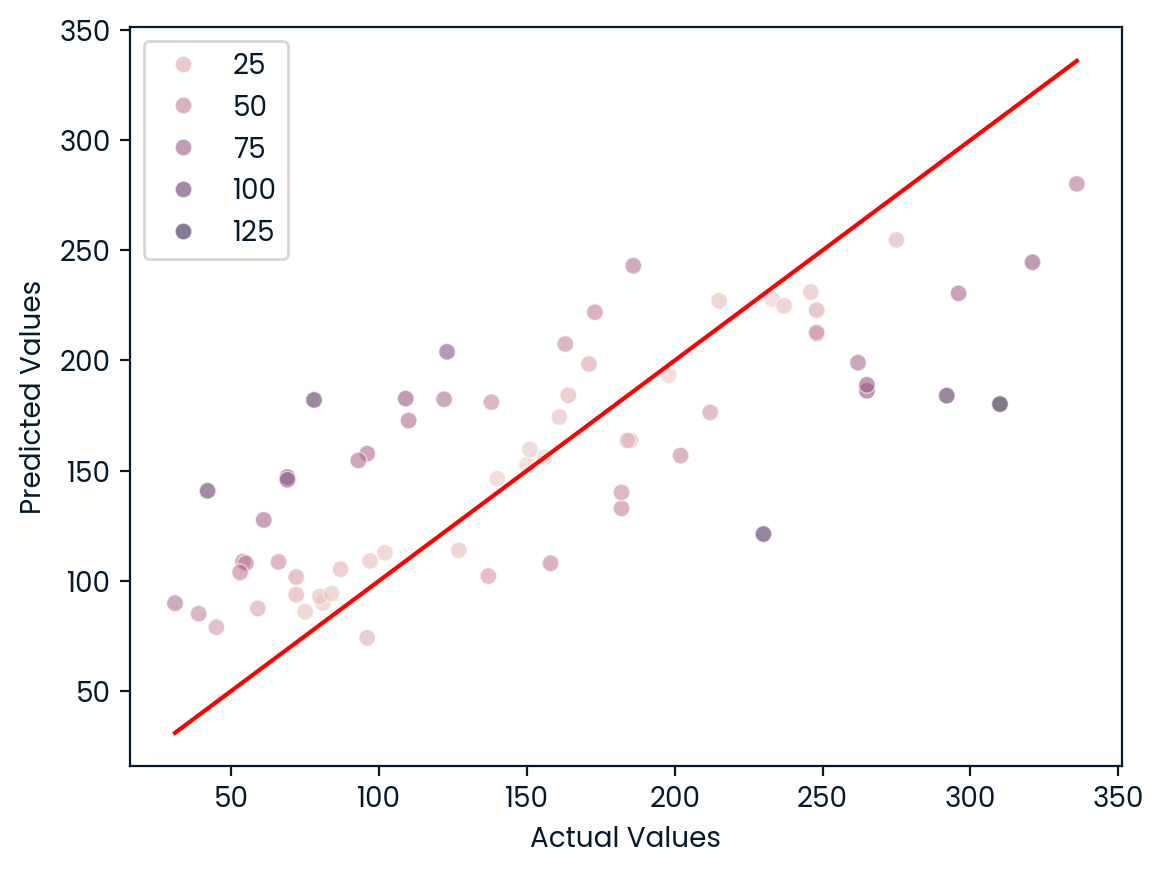

In [29]:
actual, predicted = y_test.values.flatten(), y_pred.flatten()

residuals = abs(actual - predicted)
sns.scatterplot(x=actual, y=predicted, hue=residuals, alpha=0.6)
sns.lineplot(x=[actual.min(), actual.max()], y=[actual.min(), actual.max()], color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()